# Testing the PILCO framework

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
# Enable Float64 for more stable matrix inversions.
import jax
import equinox as eqx
from jax import Array, config
import jax.numpy as jnp
import numpy as np
import jax.random as jr
from jaxtyping import ArrayLike, install_import_hook, Array, Float, Int, PyTree  
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

key = jr.key(123)

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
import gymnasium as gym

In [4]:
from controllers import SumOfGaussians
from model_learning.gp_models import MGPR
from policy_learning.rollout import fit_controller, rollout_check

In [5]:
import optax as ox

from typing import Tuple

In [6]:
from IPython import display

In [7]:
from rewards import cart_pole_cost

## Globals

In [8]:
num_particles = 400

In [9]:
num_trials = 8
T_sampling = 0.05
T_exploration = 0.35
T_control = 3.0
sim_timestep = 0.01

## Generate the environments

In [10]:
env = gym.make("InvertedPendulum-v5")
env_test = gym.make("InvertedPendulum-v5", render_mode='rgb_array')

In [11]:
def remake_state(x):
    return np.array([x[0],np.sin(x[1]),np.cos(x[1]),x[2],x[3]])

In [12]:
action_dim = env.action_space.shape[0]
x, _ = env.reset()
state_dim = x.shape[0] + 1
# x is now cart_position, angle_position, cart_velocity, angle_velocity -- we are going to map it to
# cart_position, sin(angle_position), cos(angle_position), cart_velocity, angle_velocity
state = remake_state(x)
num_basis = 200
umax = 3.0

In [13]:
# Randomly sample some points
key = jr.key(42)
x, _ = env.reset()
state = remake_state(x)
states = [state]
key, subkey = jr.split(key)
u = env.action_space.sample()
actions = [u]

for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env.step(np.array(u))
    x = z[0]
    state = remake_state(x)
    states.append(state)
    key, subkey = jr.split(key)
    u = env.action_space.sample()
    actions.append(u)

for _ in range(num_trials-1):
    x, _ = env.reset()
    state = remake_state(x)
    states.append(state)
    key, subkey = jr.split(key)
    u = env.action_space.sample()
    #u = exploration_policy(x,0,subkey)
    actions.append(u)
    
    for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
        z = env.step(np.array(u))
        x = z[0]
        state = remake_state(x)
        states.append(state)
        key, subkey = jr.split(key)
        u = env.action_space.sample()
        actions.append(u)
    

In [14]:
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))

In [15]:
%%time
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))
model.optimize()
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))

32.95606353624121
-273.3330551706267
CPU times: user 15 s, sys: 3.56 s, total: 18.5 s
Wall time: 6.43 s


In [16]:
st = jnp.array(states)
pm = model.predict_all_outputs(jnp.hstack((st,jnp.array(actions))))

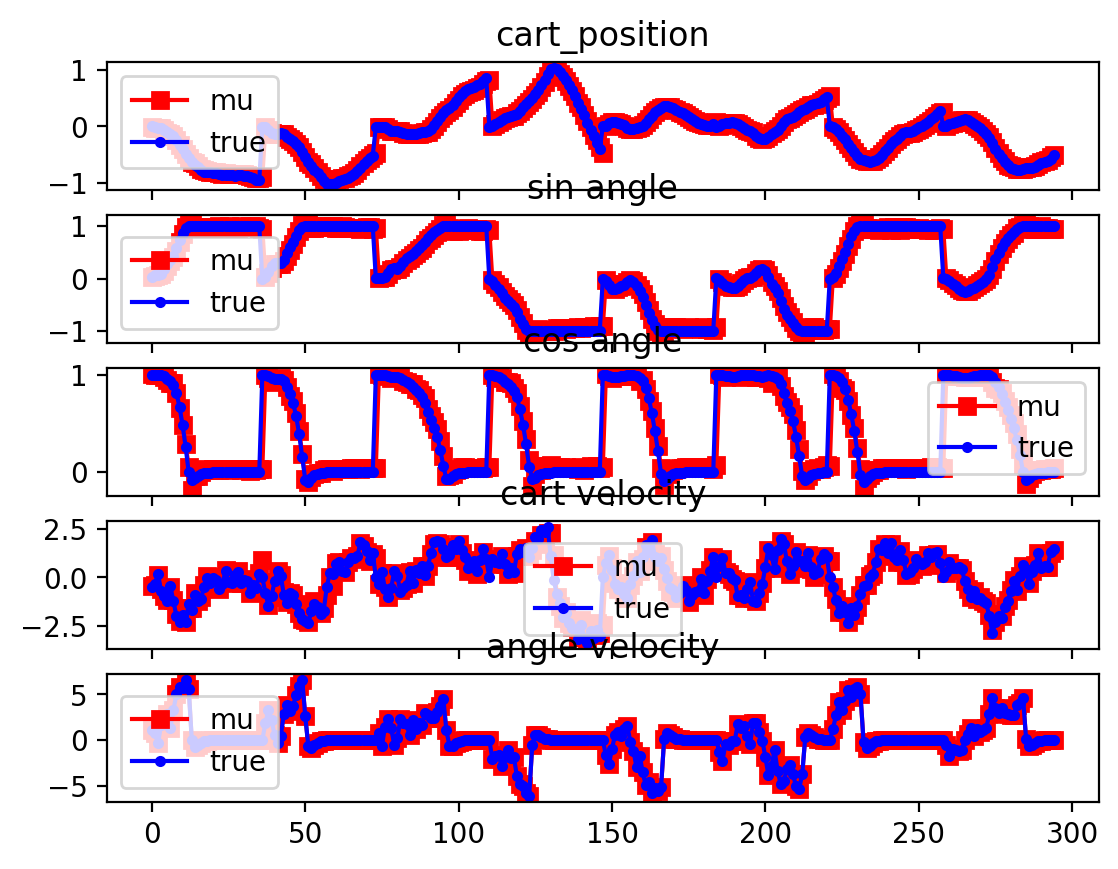

In [17]:
titles = ['cart_position','sin angle','cos angle', 'cart velocity','angle velocity']
fig, ax = plt.subplots(state_dim,1,sharex=True)
for i in range(state_dim):
    ax[i].plot(pm[:-1,i,0],color='red',label='mu',marker='s')
    ax[i].plot(st[1:,i],color='blue',label='true',marker='.')
    ax[i].legend();
    ax[i].set_title(titles[i]);

### Rollout

In [18]:
control_policy = SumOfGaussians(
    state_dim, 
    action_dim, 
    num_basis, 
    initial_log_lengthscales = None,
    initial_centers=None,
    use_dropout = True,
    dropout_probability = 0.2,
    to_squash=True, 
    max_action=umax
)

In [19]:
control_horizon = int(T_control/T_sampling)

In [20]:
optimizer = ox.adam(learning_rate=ox.linear_schedule(init_value=1e-2, end_value=1e-6, transition_steps=100))

In [21]:
%%time
control_policy, losses = fit_controller(
    policy=control_policy,
    env=env,
    num_particles=num_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    obj_func=cart_pole_cost,
    optim=optimizer,
    num_iters=250
)

step=0, train_loss=56.60722936009771, 
step=100, train_loss=54.819678784528165, 
step=200, train_loss=54.81967721595014, 
step=249, train_loss=54.819676161183125, 
CPU times: user 5min 58s, sys: 6min 7s, total: 12min 5s
Wall time: 1min 52s


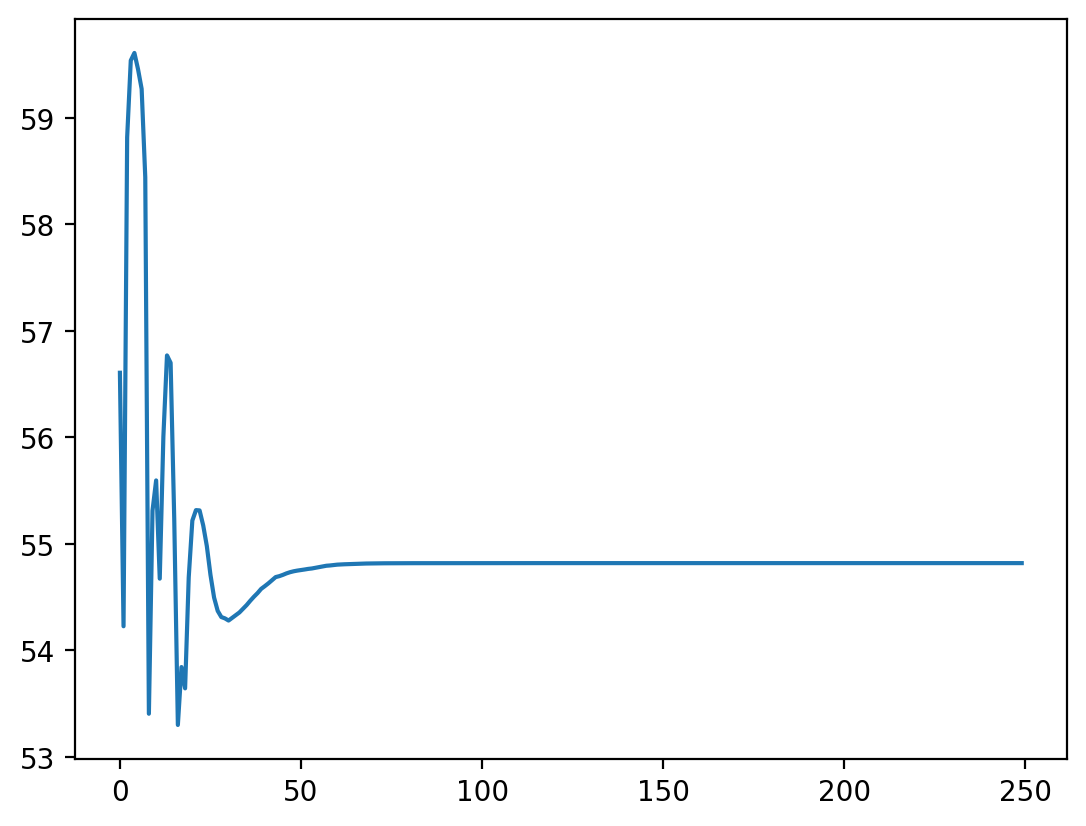

In [22]:
plt.plot(losses)

In [24]:
x, _ = env.reset()
state = remake_state(x)
key, subkey = jr.split(key)
# Generate an initial (random) action
u = env.action_space.sample()
# initialize some particles
timesteps=jnp.arange(control_horizon)
samples = model.get_samples(key, jnp.array([state]), jnp.array([u]), num_particles)
all_samples = [samples]
for t in timesteps:
    actions = jax.vmap(control_policy)(samples, jnp.tile(timestep, num_particles))
    key, subkey = jr.split(key)
    samples = model.get_samples(key, samples, actions, 1)
    all_samples.append(samples)
    cost = jnp.mean(jax.vmap(cart_pole_cost)(jnp.hstack((samples, actions))))
    print(t,cost)
all_samples = jnp.array(all_samples)

0 0.9965046988856954
1 0.997618644001082
2 0.999128893470564
3 0.9984754921008059
4 0.9997213634625532
5 0.9991548625437282
6 0.9990808938197349
7 0.9997258203389398
8 0.9995928272846765
9 0.9954089548251918
10 0.9958206035121382
11 0.9997705500091684
12 0.9997792222685372
13 0.9999230440810911
14 0.9991003062090775
15 0.9979565488944677
16 0.9996388947573489
17 0.9994675876859187
18 0.9984404154164703
19 0.9810358549717902
20 0.9912572408628849
21 0.9960687988614592
22 0.96667037879335
23 0.9998265030402285
24 0.9245700791093977
25 0.9999968770616552
26 0.9999999999079837
27 1.0
28 1.0
29 1.0
30 1.0
31 1.0
32 1.0
33 1.0
34 1.0
35 1.0
36 1.0
37 1.0
38 1.0
39 1.0
40 1.0
41 1.0
42 1.0
43 1.0
44 1.0
45 1.0
46 1.0
47 1.0
48 1.0
49 1.0
50 1.0
51 1.0
52 1.0
53 1.0
54 1.0
55 1.0
56 1.0
57 1.0
58 1.0
59 1.0


In [25]:
all_samples.shape

(61, 400, 5)

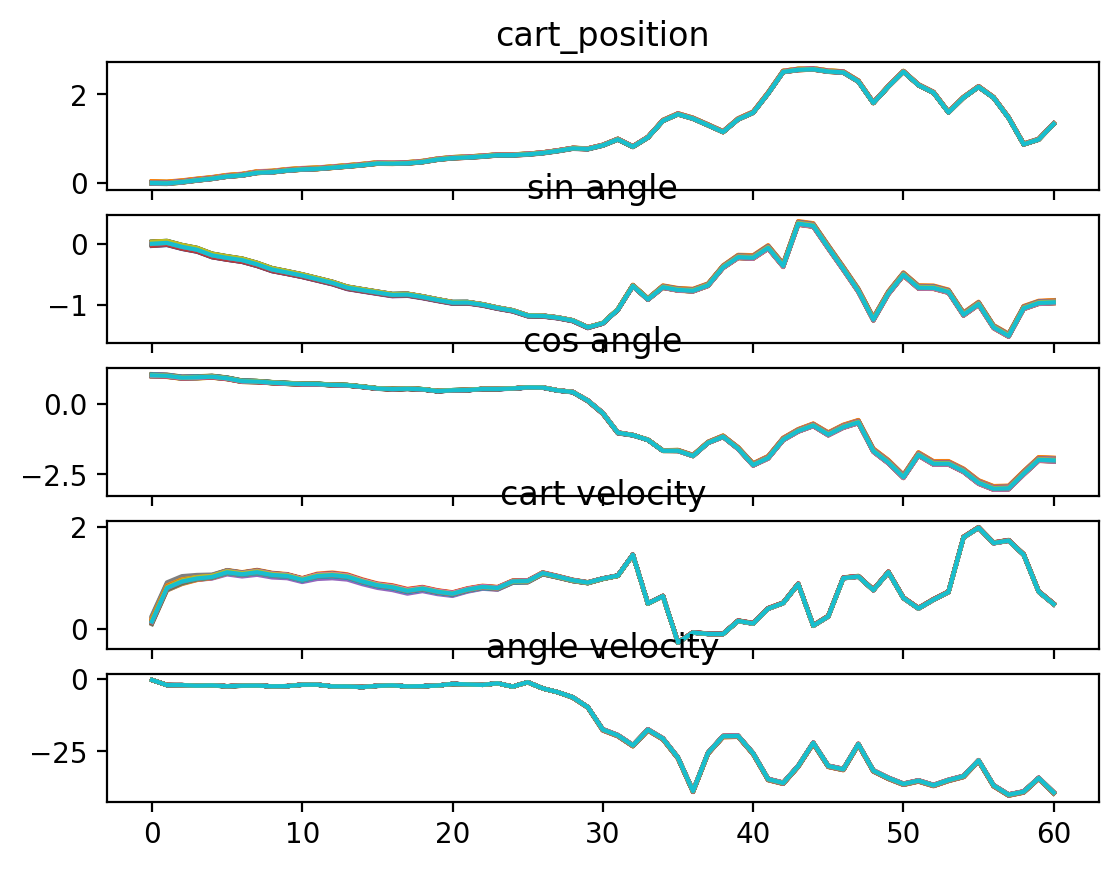

In [26]:
titles = ['cart_position','sin angle','cos angle', 'cart velocity','angle velocity']
fig, ax = plt.subplots(state_dim,1,sharex=True)
for i in range(state_dim):
    for particle in range(100):
        ax[i].plot(all_samples[:,particle,i])
    ax[i].set_title(titles[i]);
plt.show()

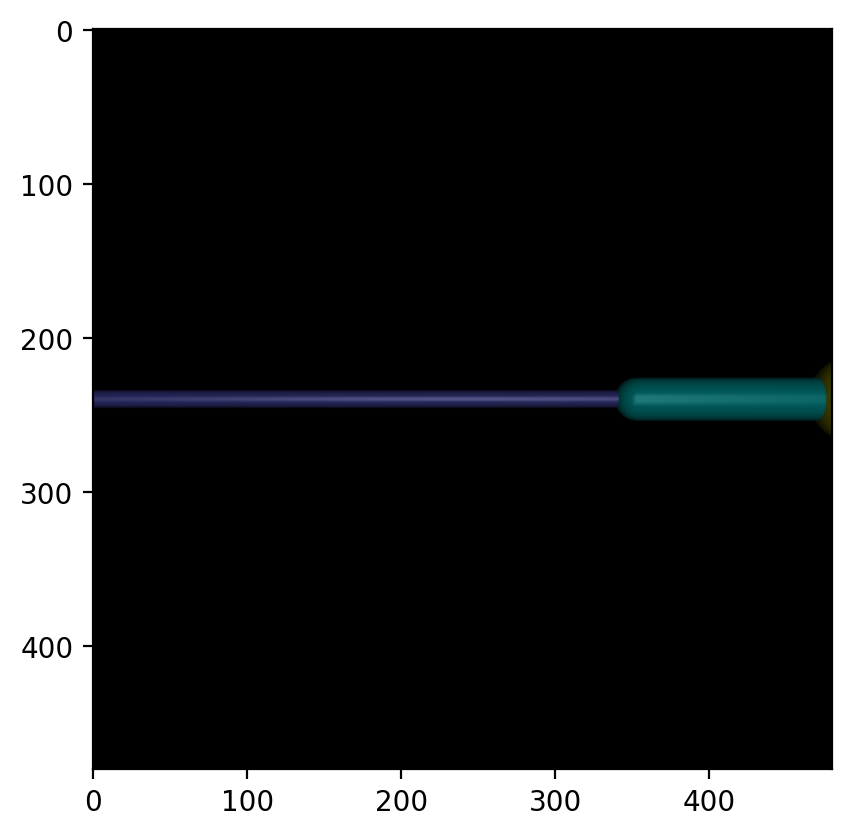

In [23]:
# Now try this policy on the real system
x, _ = env_test.reset()
key, subkey = jr.split(key)
u = control_policy(x,timestep)
# Randomly sample some points
states.append(x)
actions.append(u)
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(x,timestep)
    states.append(x)
    actions.append(u)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [24]:
%%time
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))
model.optimize()
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))

28.752013901523895
-263.3052372602698
CPU times: user 19.2 s, sys: 4.78 s, total: 23.9 s
Wall time: 7.75 s


## Visualize how well the model is predicting the next state

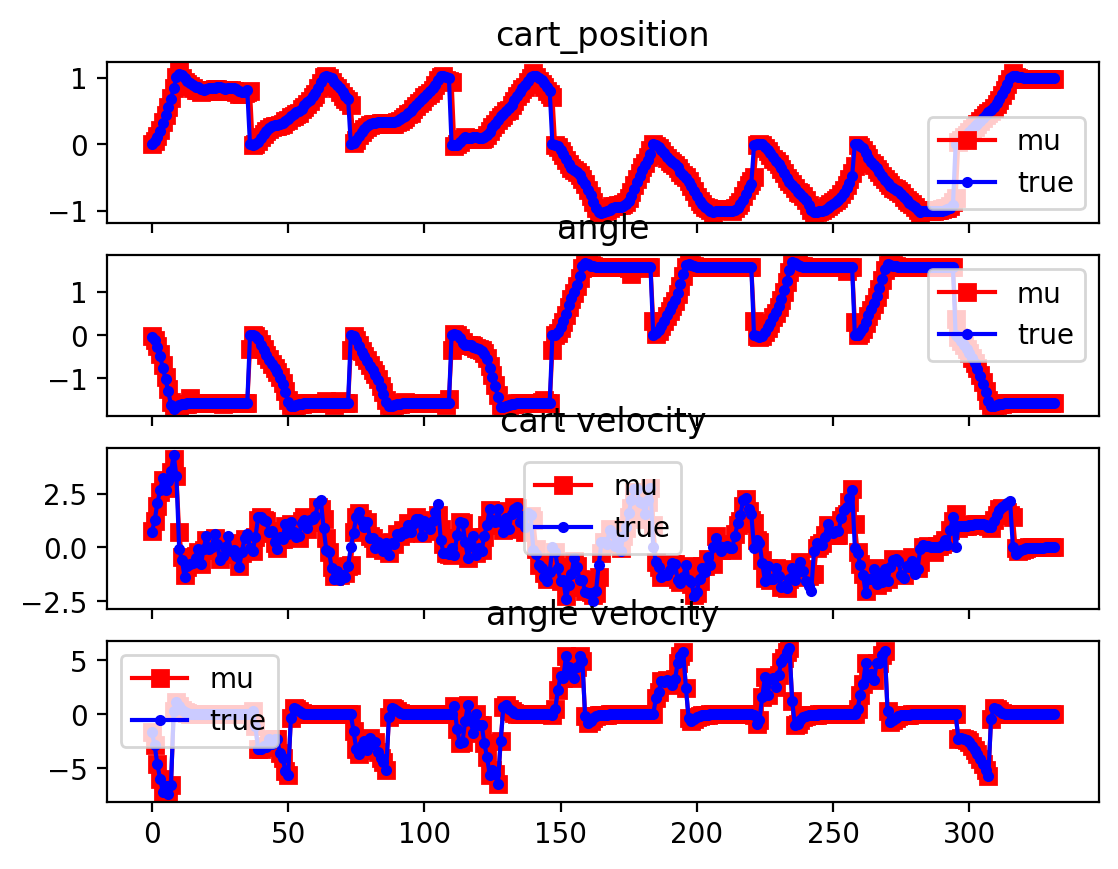

In [25]:
st = jnp.array(states)
pm = model.predict_all_outputs(jnp.hstack((st,jnp.array(actions))))
titles = ['cart_position','angle','cart velocity','angle velocity']
fig, ax = plt.subplots(4,1,sharex=True)
for i in range(4):
    ax[i].plot(pm[:-1,i,0],color='red',label='mu',marker='s')
    ax[i].plot(st[1:,i],color='blue',label='true',marker='.')
    ax[i].legend();
    ax[i].set_title(titles[i]);

In [44]:
%%time
control_policy, losses = fit_controller(
    policy=control_policy,
    env=env,
    num_particles=num_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    optim=optimizer,
    num_iters=250
)

step=0, train_loss=59.63054150702363, 
step=100, train_loss=56.58392672286441, 
step=200, train_loss=56.57963369717053, 
step=249, train_loss=56.57899509631781, 
CPU times: user 4min 35s, sys: 5min 1s, total: 9min 36s
Wall time: 1min 34s


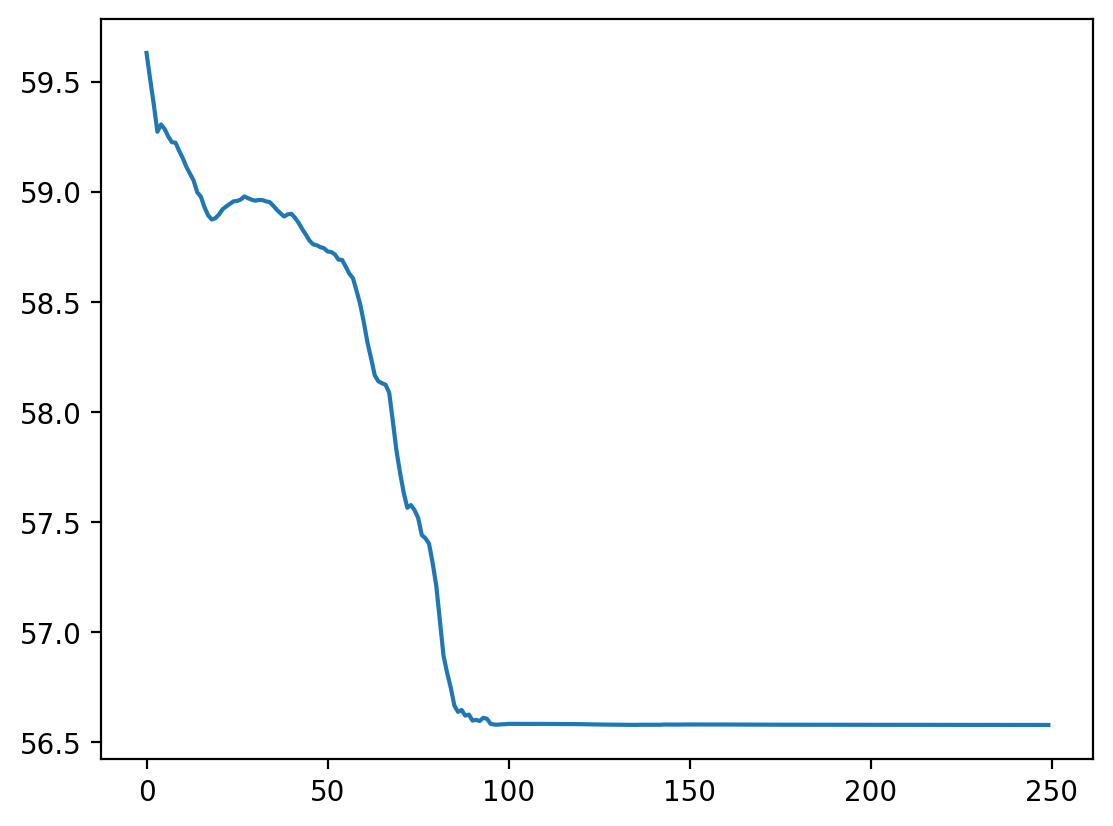

In [45]:
plt.plot(losses)

In [49]:
%%time
control_policy, losses = fit_controller(
    policy=control_policy,
    env=env,
    num_particles=num_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    optim=optimizer,
    num_iters=250
)

step=0, train_loss=56.455794207191154, 
step=100, train_loss=49.49548084228866, 
step=200, train_loss=49.49057720220639, 
step=249, train_loss=49.4882239903112, 
CPU times: user 4min 34s, sys: 4min 50s, total: 9min 24s
Wall time: 1min 31s


55.468910154980236


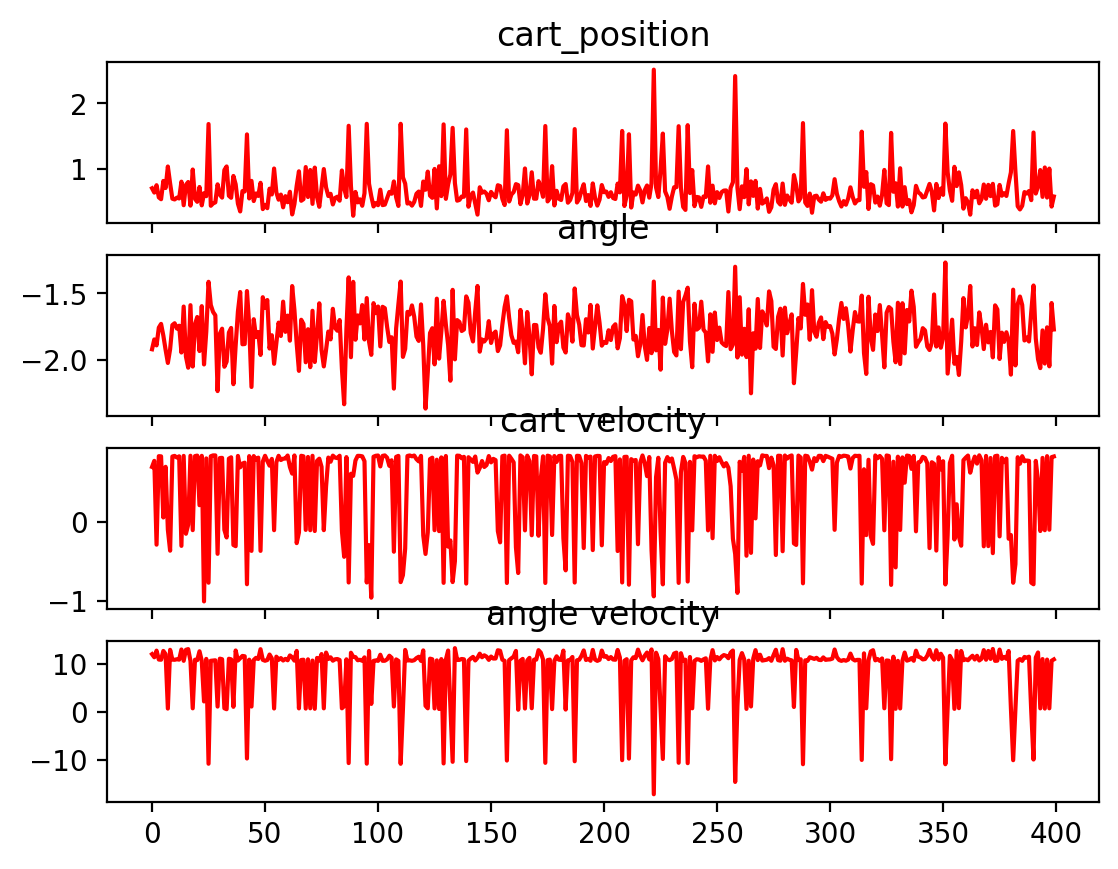

In [46]:
cost, samps = rollout_check(
    control_policy,
    env,
    num_particles,
    model,
    jnp.arange(control_horizon),
)
print(cost)
titles = ['cart_position','angle','cart velocity','angle velocity']
fig, ax = plt.subplots(4,1,sharex=True)
for i in range(4):
    ax[i].plot(samps[:,i],color='red')
    ax[i].set_title(titles[i]);
plt.show()

In [48]:
# # Now try this policy on the real system
# x, _ = env_test.reset()
# key, subkey = jr.split(key)
# u = control_policy(x,timestep)
# # Randomly sample some points
# states.append(x)
# actions.append(u)
# img = plt.imshow(env_test.render()) # only call this once
# for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
#     z = env_test.step(np.array(u))
#     x = z[0]
#     r = z[1]
#     key, subkey = jr.split(key)
#     u = control_policy(x,timestep)
#     # states.append(x)
#     # actions.append(u)
#     print(x)
#     print(timestep,r)
#     img.set_data(env_test.render()) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)